# 1 正则化
Regularization: 减小方差的策略\
误差可分界为：偏差，方差与噪声之和。即`误差=偏差+方差+噪声`
- 偏差度量了学习算法的期望预测与真实结果的偏离程度，即刻画了学习算法本身的拟合能力
- 方差度量了同样大小的训练集的变动所导致的学习性能的变化，即刻画了数据扰动所造成的影响
- 噪声则表达了在当前任务上任何学习算法所能达到的期望泛化误差的下界
<img src="https://cdn.acwing.com/media/article/image/2024/10/25/291897_ea324ab692-%E5%B1%8F%E5%B9%95%E6%88%AA%E5%9B%BE-2024-10-25-154351.png"/>
## 1.1 weight decay
在使用$L_1$正则项时取得最小Cost往往在坐标轴上，因此得到的是稀疏参数\
而使用$L_2$正则项\
$Obj=Cost\ +\ Regularization\ Term$\
$Obj = Loss + \dfrac{\lambda}{2}\times \sum^{N}_i{w^2_i}$\
$w_{i+1} = w_i - \dfrac{\alpha Obj}{\alpha w_i} = w_i - \dfrac{\alpha Loss}{\alpha w_i}$\
$w_{i+1} = w_i - \dfrac{\alpha Obj}{\alpha w_i} = w_i - (\dfrac{\alpha Loss}{\alpha w_i}+\lambda \cdot w_i)$\
$=w_i(1-\lambda)-\dfrac{\alpha Loss}{\alpha w_i} (0 < \lambda < 1)$\
使得w变小，所以又称权重衰减

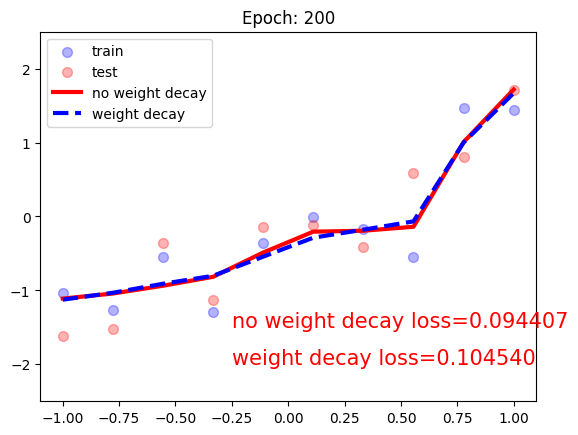

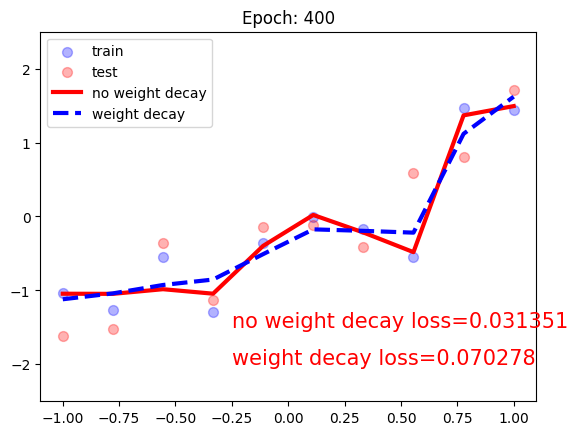

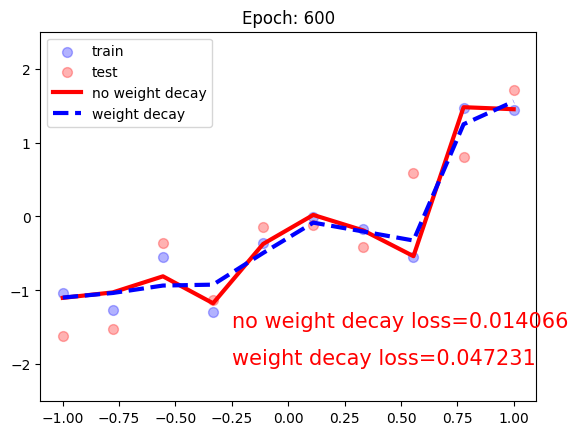

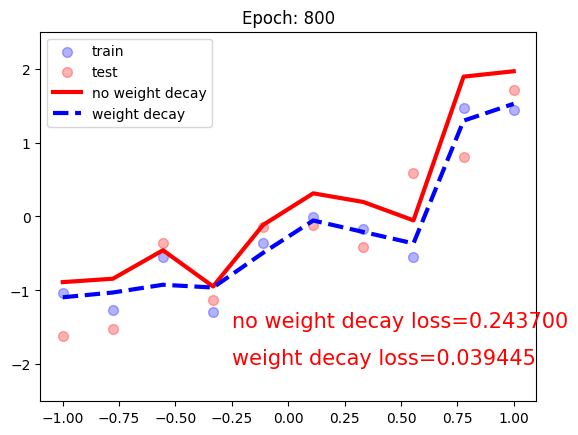

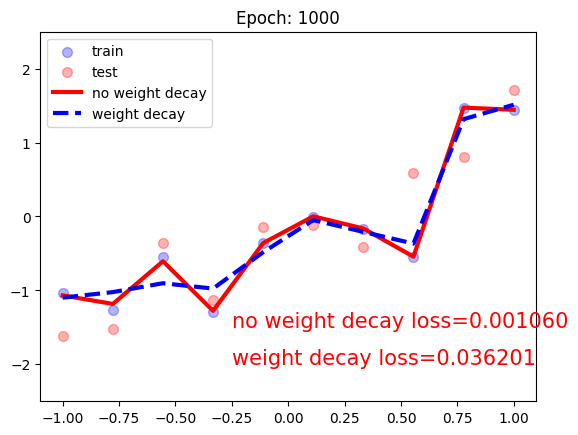

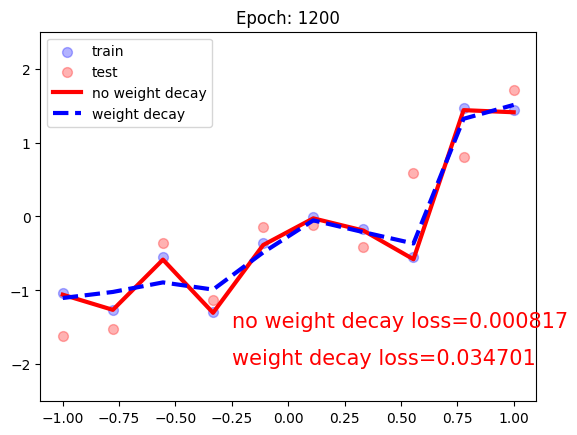

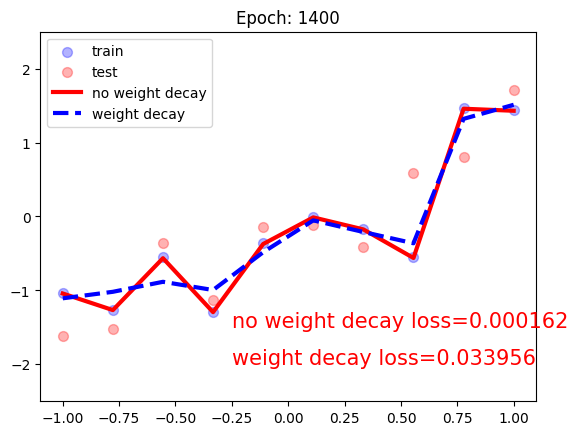

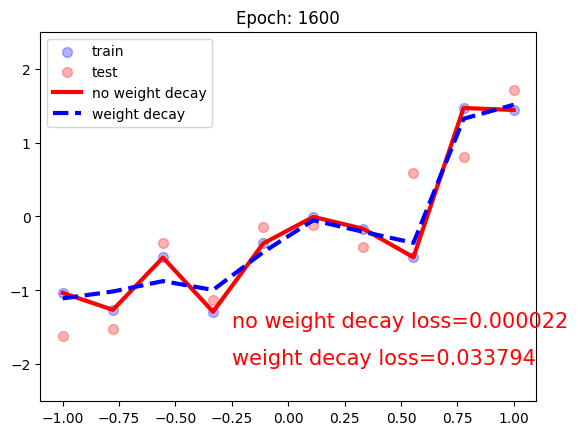

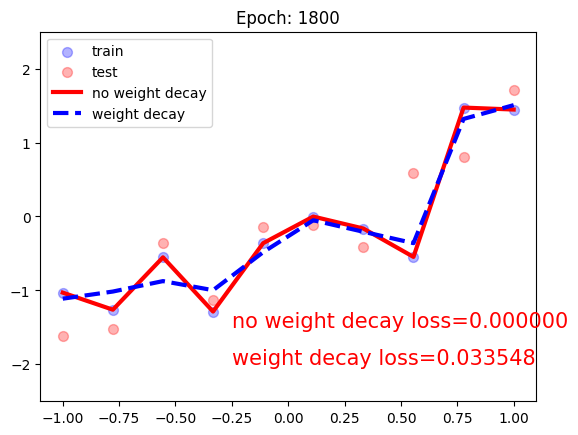

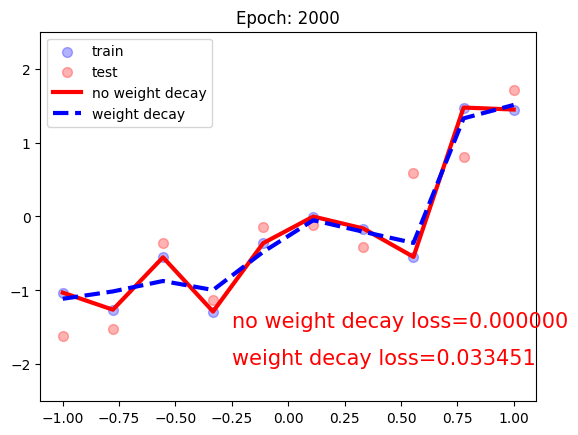

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

n_hidden = 200
max_iter = 2000
disp_interval = 200
lr_init = 0.01


# ============================ step 1/5 数据 ============================
def gen_data(num_data=10, x_range=(-1, 1)):

    w = 1.5
    train_x = torch.linspace(*x_range, num_data).unsqueeze_(1)
    train_y = w*train_x + torch.normal(0, 0.5, size=train_x.size())
    test_x = torch.linspace(*x_range, num_data).unsqueeze_(1)
    test_y = w*test_x + torch.normal(0, 0.3, size=test_x.size())

    return train_x, train_y, test_x, test_y


train_x, train_y, test_x, test_y = gen_data(x_range=(-1, 1))


# ============================ step 2/5 模型 ============================
class MLP(nn.Module):
    def __init__(self, neural_num):
        super(MLP, self).__init__()
        self.linears = nn.Sequential(
            nn.Linear(1, neural_num),
            nn.ReLU(inplace=True),
            nn.Linear(neural_num, neural_num),
            nn.ReLU(inplace=True),
            nn.Linear(neural_num, neural_num),
            nn.ReLU(inplace=True),
            nn.Linear(neural_num, 1),
        )

    def forward(self, x):
        return self.linears(x)


net_normal = MLP(neural_num=n_hidden)
net_weight_decay = MLP(neural_num=n_hidden)

# ============================ step 3/5 优化器 ============================
optim_normal = torch.optim.SGD(net_normal.parameters(), lr=lr_init, momentum=0.9)
optim_wdecay = torch.optim.SGD(net_weight_decay.parameters(), lr=lr_init, momentum=0.9, weight_decay=1e-2)

# ============================ step 4/5 损失函数 ============================
loss_func = torch.nn.MSELoss()

# ============================ step 5/5 迭代训练 ============================

writer = SummaryWriter(comment='_test_tensorboard', filename_suffix="12345678")
for epoch in range(max_iter):

    # forward
    pred_normal, pred_wdecay = net_normal(train_x), net_weight_decay(train_x)
    loss_normal, loss_wdecay = loss_func(pred_normal, train_y), loss_func(pred_wdecay, train_y)

    optim_normal.zero_grad()
    optim_wdecay.zero_grad()

    loss_normal.backward()
    loss_wdecay.backward()

    optim_normal.step()
    optim_wdecay.step()

    if (epoch+1) % disp_interval == 0:

        # 可视化
        for name, layer in net_normal.named_parameters():
            writer.add_histogram(name + '_grad_normal', layer.grad, epoch)
            writer.add_histogram(name + '_data_normal', layer, epoch)

        for name, layer in net_weight_decay.named_parameters():
            writer.add_histogram(name + '_grad_weight_decay', layer.grad, epoch)
            writer.add_histogram(name + '_data_weight_decay', layer, epoch)

        test_pred_normal, test_pred_wdecay = net_normal(test_x), net_weight_decay(test_x)

        # 绘图
        plt.scatter(train_x.data.numpy(), train_y.data.numpy(), c='blue', s=50, alpha=0.3, label='train')
        plt.scatter(test_x.data.numpy(), test_y.data.numpy(), c='red', s=50, alpha=0.3, label='test')
        plt.plot(test_x.data.numpy(), test_pred_normal.data.numpy(), 'r-', lw=3, label='no weight decay')
        plt.plot(test_x.data.numpy(), test_pred_wdecay.data.numpy(), 'b--', lw=3, label='weight decay')
        plt.text(-0.25, -1.5, 'no weight decay loss={:.6f}'.format(loss_normal.item()), fontdict={'size': 15, 'color': 'red'})
        plt.text(-0.25, -2, 'weight decay loss={:.6f}'.format(loss_wdecay.item()), fontdict={'size': 15, 'color': 'red'})

        plt.ylim((-2.5, 2.5))
        plt.legend(loc='upper left')
        plt.title("Epoch: {}".format(epoch+1))
        plt.show()
        plt.close()

---
## 1.2 Dropout
Dropout:随机失活\
随机：dropout probability\
失活：weight = 0\
数据尺度变化：测试时，所有权重乘以 1 - drop_prob
因此pytorch在实现时，会在训练时就将权重乘以$\dfrac{1}{1-p}$, 这样测试时就不需要再进行权重乘1 - drop_prob操作
### - nn.Dropout
功能：Dropout层
参数：
- p：被舍弃概率，失活概率
Dropout通常放在需要加入dropout的网络层的前一层

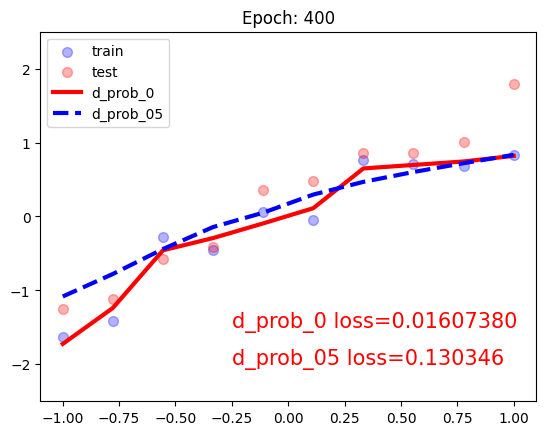

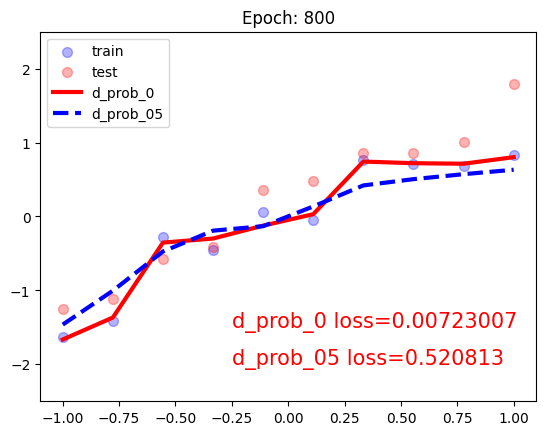

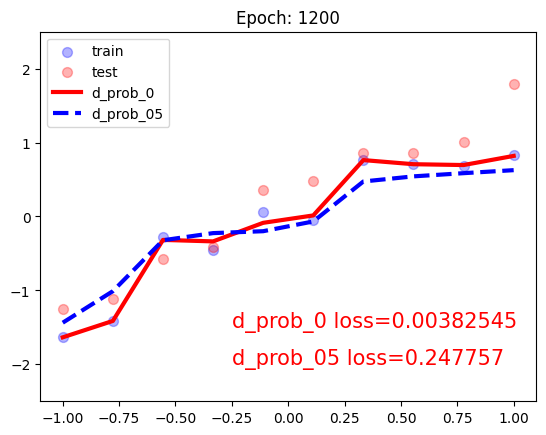

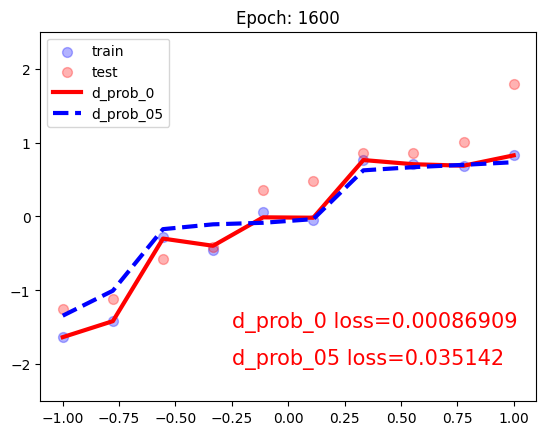

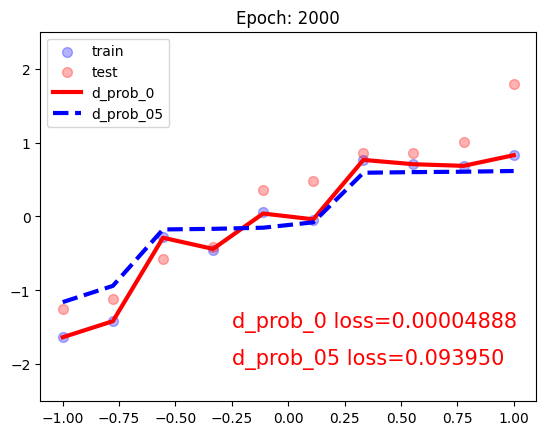

In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

n_hidden = 200
max_iter = 2000
disp_interval = 400
lr_init = 0.01


# ============================ step 1/5 数据 ============================
def gen_data(num_data=10, x_range=(-1, 1)):

    w = 1.5
    train_x = torch.linspace(*x_range, num_data).unsqueeze_(1)
    train_y = w*train_x + torch.normal(0, 0.5, size=train_x.size())
    test_x = torch.linspace(*x_range, num_data).unsqueeze_(1)
    test_y = w*test_x + torch.normal(0, 0.3, size=test_x.size())

    return train_x, train_y, test_x, test_y


train_x, train_y, test_x, test_y = gen_data(x_range=(-1, 1))


# ============================ step 2/5 模型 ============================
class MLP(nn.Module):
    def __init__(self, neural_num, d_prob=0.5):
        super(MLP, self).__init__()
        self.linears = nn.Sequential(

            nn.Linear(1, neural_num),
            nn.ReLU(inplace=True),

            nn.Dropout(d_prob),
            nn.Linear(neural_num, neural_num),
            nn.ReLU(inplace=True),

            nn.Dropout(d_prob),
            nn.Linear(neural_num, neural_num),
            nn.ReLU(inplace=True),

            nn.Dropout(d_prob),
            nn.Linear(neural_num, 1),
        )

    def forward(self, x):
        return self.linears(x)


net_prob_0 = MLP(neural_num=n_hidden, d_prob=0.)
net_prob_05 = MLP(neural_num=n_hidden, d_prob=0.5)

# ============================ step 3/5 优化器 ============================
optim_normal = torch.optim.SGD(net_prob_0.parameters(), lr=lr_init, momentum=0.9)
optim_reglar = torch.optim.SGD(net_prob_05.parameters(), lr=lr_init, momentum=0.9)

# ============================ step 4/5 损失函数 ============================
loss_func = torch.nn.MSELoss()

# ============================ step 5/5 迭代训练 ============================

writer = SummaryWriter(comment='_test_tensorboard', filename_suffix="12345678")
for epoch in range(max_iter):

    pred_normal, pred_wdecay = net_prob_0(train_x), net_prob_05(train_x)
    loss_normal, loss_wdecay = loss_func(pred_normal, train_y), loss_func(pred_wdecay, train_y)

    optim_normal.zero_grad()
    optim_reglar.zero_grad()

    loss_normal.backward()
    loss_wdecay.backward()

    optim_normal.step()
    optim_reglar.step()

    if (epoch+1) % disp_interval == 0:

        net_prob_0.eval()
        net_prob_05.eval()#由于加入dropout网络训练和测试采用的方法不一样，所以要先设定网络为测试的状态

        # 可视化
        for name, layer in net_prob_0.named_parameters():
            writer.add_histogram(name + '_grad_normal', layer.grad, epoch)
            writer.add_histogram(name + '_data_normal', layer, epoch)

        for name, layer in net_prob_05.named_parameters():
            writer.add_histogram(name + '_grad_regularization', layer.grad, epoch)
            writer.add_histogram(name + '_data_regularization', layer, epoch)

        test_pred_prob_0, test_pred_prob_05 = net_prob_0(test_x), net_prob_05(test_x)

        # 绘图
        plt.scatter(train_x.data.numpy(), train_y.data.numpy(), c='blue', s=50, alpha=0.3, label='train')
        plt.scatter(test_x.data.numpy(), test_y.data.numpy(), c='red', s=50, alpha=0.3, label='test')
        plt.plot(test_x.data.numpy(), test_pred_prob_0.data.numpy(), 'r-', lw=3, label='d_prob_0')
        plt.plot(test_x.data.numpy(), test_pred_prob_05.data.numpy(), 'b--', lw=3, label='d_prob_05')
        plt.text(-0.25, -1.5, 'd_prob_0 loss={:.8f}'.format(loss_normal.item()), fontdict={'size': 15, 'color': 'red'})
        plt.text(-0.25, -2, 'd_prob_05 loss={:.6f}'.format(loss_wdecay.item()), fontdict={'size': 15, 'color': 'red'})

        plt.ylim((-2.5, 2.5))
        plt.legend(loc='upper left')
        plt.title("Epoch: {}".format(epoch+1))
        plt.show()
        plt.close()

        net_prob_0.train()# 最后要重新设置回训练的状态
        net_prob_05.train()

---
## 1.3 Batch Normalization
Batch Normalization: 批标准化\
批：一批数据，通常为mini-batch\
标准化：0均值，1方差\
BN层在激活函数之前使用\
优点：
- 可以用更大学习率，加速模型收敛
- 可以不用精心设计权重初始化
- 可以不用dropout或用较小的dropout
- 可以不用L2或者用较小的weight decay
- 可以不同LRN（local response normalization）

### _BatchNorm
每个特征的标准差和方差是在batch维度统计的
- nn.BatchNorm1d
- nn.BatchNorm2d
- nn.BatchNorm3d\
**参数：**
- num_features:一个样本特征数量（最重要）
- eps：分母修正项
- momentum：指数加权平均估计当前mean/var
- affine: 是否需要affine transform
- track_running_stats: 是训练状态，还是测试状态\
**主要属性：**
- running_mean: 均值
- running_var: 方差
- weight: affine transform中的$\gamma$
- bias: affine transform中的$\beta$\
训练阶段均值和方差采用指数加权平均计算，而测试阶段是使用训练好的统计值
$running\_mean = (1 - momentum) * pre\_running\_mean + momentum * mean_t$
$running\_var = (1 - momentum) * pre\_running\_var + momentum * var_t$

```
nn.BatchNorm?d input = B*特征数*?d特征
```
---
## 1.4 Other Normalization
不同之处在于均值和方差的求取方式
### Layer Normalization
起因：BN不适用于边长的网络，如RNN\
思路：`逐层`计算均值和方差\

注意事项：
1. 不再有running_mean和running_var
2. $\gamma$和$\beta$是逐元素的

### - nn.LayerNarm
主要参数：
- normalized_shape:该层特征形状
- eps：分母修正项
- elementwise_affine: 是否需要affine transform

### Instance Normalization
起因：BN在图像生成 (image Generation) 中不适用
思路：逐Instance (channel) 计算均值和方差

### - nn.InstanceNorm
主要参数：
- num_features: 一个样本特征数量（最重要）
- eps：分母修正项
- momentum：指数加权平均估计当前mean/var
- affine: 是否需要affine transform
- track_running_stats: 是训练状态，还是测试状态
注意：和batch normalization一样也有一维，二维，三维的

### Group Normalization
起因：小batch样本中，BN估计的值不准
思路：数据不够，通道来凑

注意事项:
1. 不再有running_mean和running_var
2. $\gamma$和$\beta$为逐通道(channel)的
应用场景：大模型（小batch size）任务

### - nn.GroupNorm
主要参数：
- num_group:分组数
- num_channels: 通道数（特征数）
- eps:分母修正项
- affine：是否需要affine transform